<h1><center>Final Project Analisis Media Sosial </center></h1>

Metode Naive Bayes:
1. Rizkya Alfiyyah (11200940000035)
2. Haickal Akbar (112009940000067)

## Import Modul

In [1]:
try:
    import google.colab
    print("Installing needed Modules ... ")
    !pip install textblob
    !pip install Sastrawi
    !pip install --user --upgrade nest_asyncio
    !pip install dash
    !pip install wordcloud
    !pip install transformers
    !pip install torch
    !pip install unidecode
    #!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
except:
    #IN_COLAB = False
    print("Running the notebook locally ...  ")
    pass

Installing needed Modules ... 


In [28]:
import time, numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
import re
from html import unescape
from tqdm import tqdm
import nltk
from nltk import word_tokenize
from unidecode import unidecode
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# modul scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# modul impor file
import urllib.request

# modul dashboard
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Data

In [3]:
# Loading Data
try:
    data1 = pd.read_csv('data/data-sentimen/dataset_komentar_instagram_cyberbullying.csv')
    data2 = pd.read_csv('data/data-sentimen/dataset_tweet_sentimen_tayangan_tv.csv')
    data3 = pd.read_csv('data/data-sentimen/dataset_tweet_sentiment_cellular_service_provider.csv')
    data4 = pd.read_csv('data/data-sentimen/dataset_tweet_sentiment_opini_film.csv')
    data5 = pd.read_csv('data/data-sentimen/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
    print("Loaded from local file.")
except:
    data1 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_komentar_instagram_cyberbullying.csv')
    data2 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentimen_tayangan_tv.csv')
    data3 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_cellular_service_provider.csv')
    data4 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_opini_film.csv')
    data5 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
    print("Loaded from Github.")

Loaded from Github.


In [4]:
data1.drop(columns=['Id'], inplace=True)
data1.rename(columns={'Instagram Comment Text': 'Tweet'}, inplace=True)

data2.drop(columns=['Id', 'Acara TV', 'Jumlah Retweet'], inplace=True)
data2.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data3.drop(columns=['Id'], inplace=True)
data3.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data4.drop(columns=['Id'], inplace=True)
data4.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data5.drop(columns=['Id', 'Pasangan Calon'], inplace=True)
data5.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

# Data dijadikan satu
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)
data.head()

,Sentiment,Tweet
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


## Duplicate Data

In [46]:
data[data.duplicated()==True]
# memeriksa duplikasi
print(data.duplicated().sum())
# membuang duplikasi
data.drop_duplicates(inplace=True)
print(data.shape)

0
(2, 3)


## Preprocessing Data

# Stopword

In [6]:
url = 'https://raw.githubusercontent.com/taudataid/eLearning/master/data/stopwords_id.txt'
response = urllib.request.urlopen(url)
stopword_id = response.read().decode('utf-8').split('\n')

print("jumlah stopword: ", len(stopword_id))

jumlah stopword:  758


In [7]:
# modifikasi sesuka hati jika dirasa masih ada stopword yang belum tertangani
stopword_tambahan = set(['a', 'ahok', 'ahy',
                         'b', 'bikin',
                         'c',
                         'd', 'daerah', 'dki',
                         'e',
                         'f', 'face', 'film',
                         'g',
                         'h', 'hand', 'hitam',
                         'i', 'ibukota',
                         'j', 'jakarta',
                         'k', 'khusus', 'kepala', 'keluarga',
                         'l',
                         'm', 'mata', 'mbak',
                         'n', 'name', 'nonton', 'najwa', 'nya',
                         'o', 'orang',
                         'p', 'provider', 'putih', 'pak',
                         'q',
                         'r',
                         's', 'smilling', 'si',
                         't',
                         'u', 'username',
                         'v',
                         'w', 'with',
                         'x',
                         'y',
                         'z'])
stopword_id = set(stopword_id).union(stopword_tambahan)

# mengandung makna
remove = {'tidak', 'bukan', 'mau', 'sangat'}
stopword_id.difference_update(remove)

print("jumlah stopword: ", len(stopword_id))

jumlah stopword:  806


# Slang

In [48]:
url = 'https://raw.githubusercontent.com/taudataid/eLearning/master/data/slang.dic'
response = urllib.request.urlopen(url)
slang_id = eval(response.read())

print("jumlah slang: ", len(slang_id))

jumlah slang:  1629


In [49]:
# modifikasi sesuka hati jika dirasa masih ada slang yang belum tertangani
slang_tambahan= {'gan':'juragan', 'jgn':'jangan', 'yg':'yang', 'dgn':'dengan', 'u': 'you', 'acu':'aku', 'gitu':'begitu', 'ndak':'tidak', 'sesok':'besok', 'udh':'sudah', 'sdh':'sudah', 'dlm':'dalam', 'dgn':'dengan', 'sm':'sama', 'utk':'untuk', 'akn':'akan',
         'stlh':'setelah', 'stlah':'setelah','stelah':'setelah', 'mrupakan':'merupakan', 'ttg':'tentang', 'kpd':'kepada', 'krn':'karena', 'ngr':'negara', 'dukun':'dukung', 'ribu':'ribut',
         'emng':'memang', 'kalo':'kalau', 'jk':'jika', 'kl':'kalau', 'klo':'kalau', 'thn':'tahun', 'ngabss':'abang', 'ngab':'abang', 'bang':'abang', 'sgt':'sangat', 'gak':'tidak', 'psl':'pasal', 'org':'orang',
         'tsb':'tersebut', 'sbg':'sebagai', 'hrs':'harus', 'gitu':'begitu', 'skrg':'sekarang', 'gue':'saya', 'gua':'saya', 'gw':'saya', 'bkn':'bukan', 'bln':'bulan', 'kek':'kaya', 'moga':'semoga',
         'you':'kamu', 'yaa':'iya', 'spt':'seperti', 'mjd':'menjadi', 'cmiiw':'correct me if iam wrong', 'msh':'masih', 'tntu':'tentu', 'sbuah':'sebuah', 'klu':'kalau', 'elu':'kamu', 'lu':'kamu',
         'tpi':'tetapi', 'plg':'pulang', 'kagak':'tidak', 'mmg':'memang', 'ijin':'izin', 'shg':'sehingga', 'nder':'abang', 'yth':'yang terhormat', 'kyk':'kaya', 'jdi':'jadi', 'jelas2':'jelas-jelas',
         'loe':'kamu', 'udh':'sudah', 'uda':'sudah', 'bpk':'bapak', 'sby':'surabaya', 'taun':'tahun', 'dar':'dari', 'sblm':'sebelum', 'brp':'berapa', 'ente':'kamu','terdpt':'terdapat',
         'dng':'dong', 'bgmn':'bagaimana', 'spy':'supaya', 'psl':'pasal', 'psal':'pasal', 'msk':'masuk', 'materiil':'materil', 'tntng':'tentang', 'mrpkn':'merupakan', 'cilaka':'celaka', 'mnrt':'menurut',
         'masy':'masa', 'koq':'kok', 'org2':'orang-orang', 'org':'orang', 'ntar':'nanti', 'trs':'terus', 'dnyatakn':'dinyatakan', 'prstitusi':'prostitusi', 'prbuatany':'perbuatannya', 'doang':'saja',
         'yuk':'ayo', 'trus':'terus', 'thd':'terhadap', 'bgt':'banget', 'scr':'secara', 'sob':'sobat', 'emg':'memang','cuman':'cuma', 'tsk':'tersangka', 'erti':'arti', 'aju':'aku',
         'knp':'kenapa', 'bnyk':'banyak', 'adlh':'adalah', 'gmn':'gimana', 'dri':'dari', 'ttp':'tetap', 'gpp':'tidak apa-apa', 'btw':'by the way', 'min':'admin',
         'mrk':'mereka', 'indo':'indonesia', 'byk':'banyak', 'dukun':'dukung', 'mendukun':'mendukung', 'belom':'belum', 'idup':'hidup', 'idupnya':'hidupnya', 'skarang':'sekarang'}
slang_id.update(slang_tambahan)

print("jumlah slang : ", len(slang_id))

jumlah slang :  1668


## Data Cleansing

In [40]:
def cleaning_text(text):
  # menghapus url
  url_pattern = re.compile(r'(\w+:\/\/\S+)')
  text = url_pattern.sub(' ', text)
  # menghapus hashtag
  hashtag_pattern = re.compile(r'#\w+\b')
  text = hashtag_pattern.sub(' ', text)
  # menghapus nama pengguna instagram (memuat "@")
  username_pattern = re.compile(r'@\w+\b\s*')
  text = username_pattern.sub(' ', text)
  # menghapus angka
  text = re.sub(r'\b\d+\b|[^\w\s]', '', text)
  # mengahpus simbol
  symbol_pattern = re.compile(r'[^\w\s]+')
  text = symbol_pattern.sub(' ', text)
  # menghapus karakter yang tidak diperlukan (tergantung media sosial)
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'\r', ' ', text)
  text = re.sub(r'&\w+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  # menangani huruf kapital dan spasi
  text = unidecode(unescape(text.lower().strip()))
  return text

def remove_stopword(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stopword_id]
  return ' '.join(filtered_sentence)

def stemming_and_lemmatization(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return stemmer.stem(text)

def remove_slang(text):
  text = ''.join(slang_id[p] if p in slang_id else p for p in re.split(r'(\W+)', text))
  return text

def preprocess(text):
  # cleaning text and lowercase
  output = cleaning_text(text)
  # remove slang
  output = remove_slang(output)
  # stemming and lemmatization
  output = stemming_and_lemmatization(output)
  # remove stopwords
  output = remove_stopword(output)

  return output

In [22]:
preprocessed_data = data.copy()
preprocessed_data['Tweet'] = data['Tweet'].map(preprocess)
preprocessed_data.head()

,Sentiment,Tweet
0,negative,tolol tidak hubung gugur pakai hijab syar bila...
1,negative,goblok tatacowo banget dibela2in balikanhadeww...
2,negative,kemarin termewek2 skr lengket duhhh labil bang...
3,negative,inti kesel att gausah kah anak kasi kembang ps...
4,negative,hadewwwww permpuan lgsakit jiwaknp peran utama...


In [59]:
from google.colab import files

data.to_csv('preprocessed_data.csv', index=False)
files.download('preprocessed_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VSM

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vsm = vectorizer.fit_transform(preprocessed_data["Tweet"])
vsm = vsm[vsm.getnnz(1) > 0][:, vsm.getnnz(0) > 0]  # Remove zero rows and columns
print(vsm.shape)
print(str(vectorizer.vocabulary_)[:200])

(2170, 18230)
{'tolol': 17085, 'tidak': 16546, 'hubung': 6239, 'gugur': 5595, 'pakai': 12259, 'hijab': 6125, 'syar': 15980, 'bilang': 2640, 'bayi': 2147, 'panas': 12379, 'dalem': 3950, 'woyyyy': 18055, 'otak': 1218


#Seed = 7, Test Size (70% Train dan 30% Test)

In [24]:
from sklearn.model_selection import train_test_split

seed = 7
testSize = 0.3

x_train, x_test, y_train, y_test = train_test_split(preprocessed_data["Tweet"], preprocessed_data["Sentiment"],
                                                    test_size=testSize, random_state = seed)


print(x_train.shape, x_test.shape)

(1533,) (658,)


#Metode Naive Bayes dan Performa Modelnya

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

mnb = MultinomialNB()
mnb.fit(x_train_vectorized, y_train)
y_pred = mnb.predict(x_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
print("Akurasi:", accuracy)
print(confusion_matrix(y_test, y_pred))

# performa model
print(classification_report(y_test, y_pred))

Akurasi: 0.790273556231003
[[260  70]
 [ 68 260]]
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79       330
    positive       0.79      0.79      0.79       328

    accuracy                           0.79       658
   macro avg       0.79      0.79      0.79       658
weighted avg       0.79      0.79      0.79       658



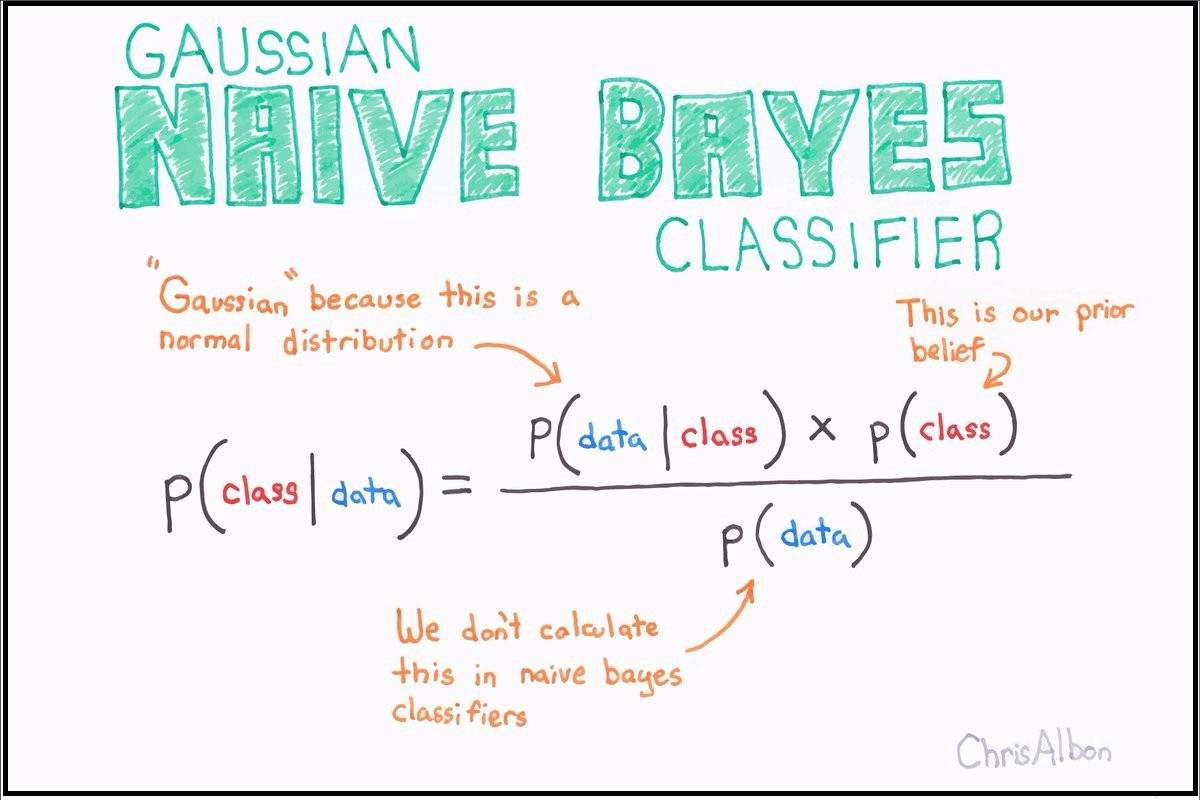

source : https://www.analisis-data.com/2018/11/algoritma-naive-bayes-classifier.html

Naive Bayes adalah metode yang cocok untuk klasifikasi biner dan multiclass. Metode yang juga dikenal sebagai Naive Bayes Classifier ini menerapkan teknik supervised klasifikasi objek di masa depan dengan menetapkan label kelas ke instance/catatan menggunakan probabilitas bersyarat. Probabilitas bersyarat adalah ukuran peluang suatu peristiwa yang terjadi berdasarkan peristiwa lain yang telah (dengan asumsi, praduga, pernyataan, atau terbukti) terjadi.

Istilah supervised merujuk pada klasifikasi training data yang sudah diberi label dengan kelas. Misalnya, sebuah transaksi penipuan telah ditandai sebagai data transaksional. Kemudian, jika Anda ingin mengklasifikasikan transaksi di masa depan menjadi fraudulent/non-fraudulent (penipuan/non-penipuan), maka jenis klasifikasi itu akan disebut sebagai supervised.
source : https://algorit.ma/blog/naive-bayes-2022/

#Cross Validasi

In [26]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

x_train, x_test, y_train, y_test = train_test_split(preprocessed_data["Tweet"], preprocessed_data["Sentiment"],
                                                    test_size=testSize, random_state = seed)
kCV = 5
metric = 'accuracy'
params = {}
params['tfidfvectorizer__min_df'] = [5, 10, 15]
params['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
params['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
params['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
params['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1, 3)]
params['multinomialnb__alpha'] = [0.1, 1.0, 10.0]

pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())
gridCV = GridSearchCV(pipe, params, cv=kCV, scoring=metric, verbose=1, n_jobs=-1)
gridCV.fit(x_train, y_train)

print(gridCV.best_score_)
print(gridCV.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.7645206616848694
{'multinomialnb__alpha': 10.0, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': True}


# Barplot Banyak Sentimen

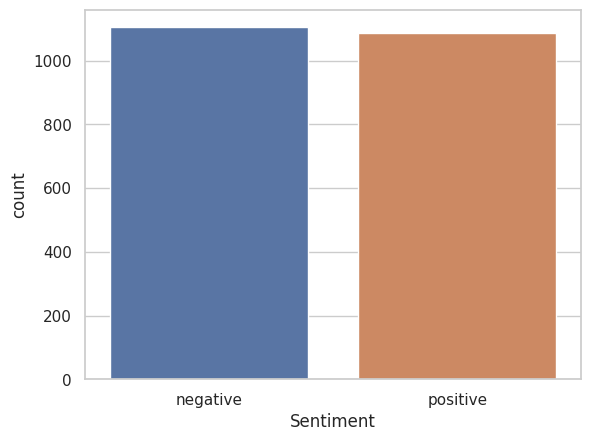

In [29]:
preprocessed_data["Sentiment"].value_counts()
sns.set_theme(style="whitegrid")

ax = sns.countplot(x=preprocessed_data["Sentiment"])
plt.show()



## Wordcloud



In [30]:
# WordCloud

def wordcloud(result, sentiment, emotion, tweet):
  result_data = result.loc[result[sentiment] == emotion]
  result_data

  allWords  = ' '.join( [str (twts) for twts in result_data[tweet]])
  wordCloud = WordCloud(background_color = "white",
                        width = 600,
                        height = 400,
                        max_words = 30,
                        colormap = 'autumn_r').generate(allWords)
  plt.figure(figsize = (10,10))
  plt.imshow(wordCloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

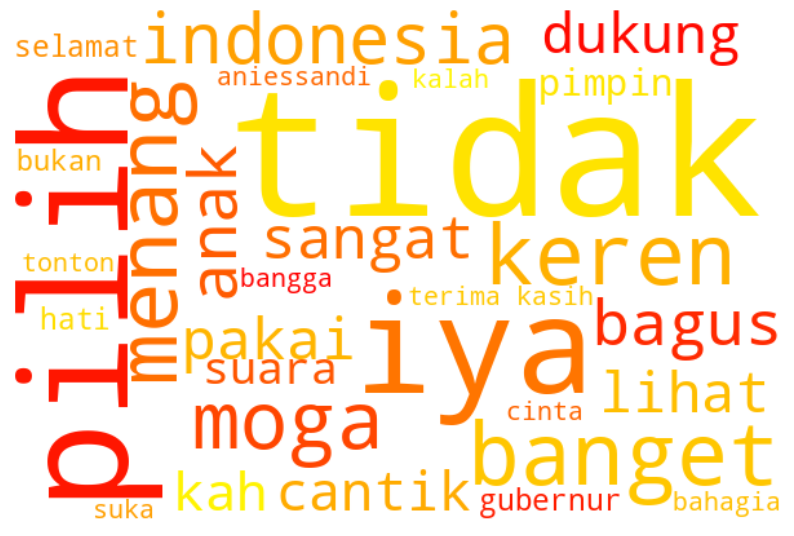

In [50]:
# WordCloud sentimen positif
wordcloud(preprocessed_data, 'Sentiment', 'positive', 'Tweet')

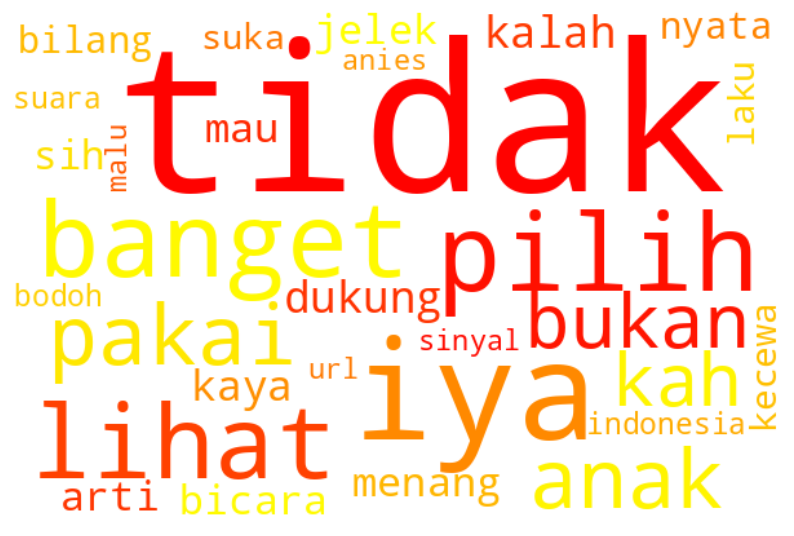

In [51]:
# WordCloud sentimen negatif
wordcloud(preprocessed_data, 'Sentiment', 'negative', 'Tweet')

## N-Gram

In [52]:
def tokenization(preprocessed_data):
    texts = preprocessed_data['Tweet']
    tokens = [token for text in texts for token in text.split()]
    return tokens

In [53]:
ngram = tokenization(preprocessed_data)
ngram[:5]

['tolol', 'tidak', 'hubung', 'gugur', 'pakai']

In [54]:
(pd.Series(nltk.ngrams(ngram, 1)).value_counts())[50:70]

(hasil,)      37
(the,)        37
(eyes,)       36
(suami,)      36
(4g,)         35
(bunga,)      35
(rakyat,)     35
(habis,)      35
(mas,)        34
(cinta,)      34
(hidup,)      34
(lancar,)     34
(cari,)       33
(bangga,)     33
(program,)    32
(kayak,)      32
(biar,)       31
(istri,)      31
(kecewa,)     31
(kuota,)      30
dtype: int64

In [55]:
bigrams_series = (pd.Series(nltk.ngrams(ngram, 2)).value_counts())[:12]
trigrams_series = (pd.Series(nltk.ngrams(ngram, 3)).value_counts())[:12]

Text(0.5, 0, '# of Occurances')

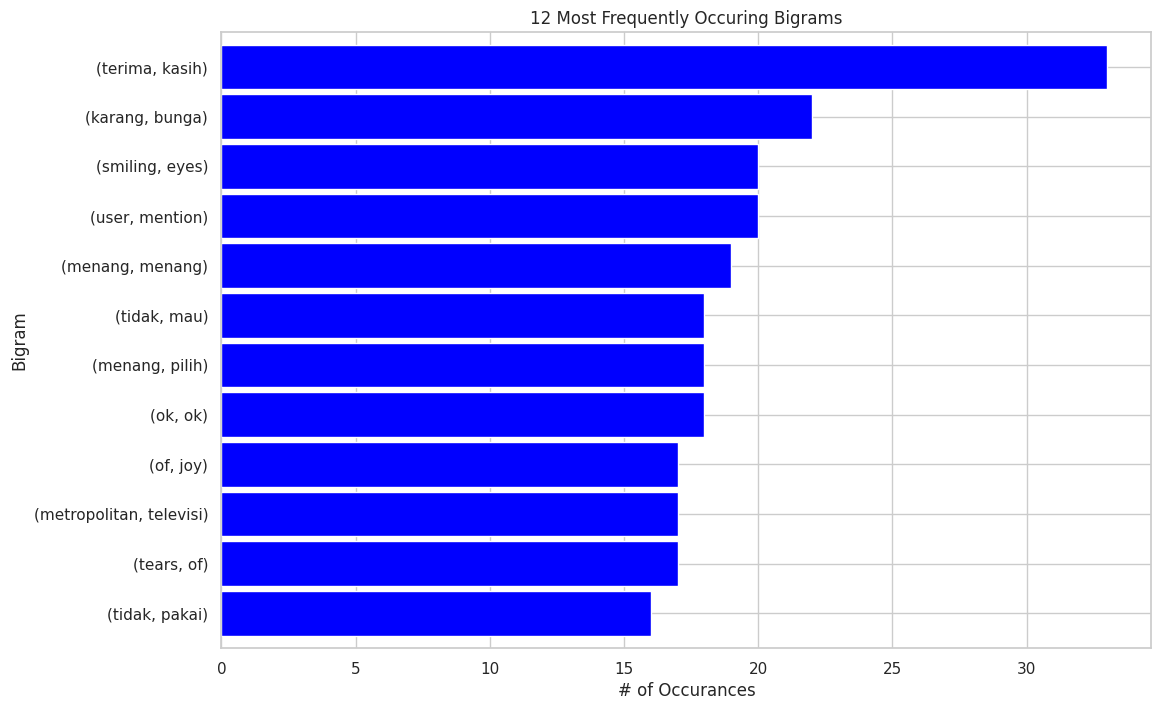

In [56]:
ax = bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('12 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

#Dashboard

In [ ]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px

app = Dash(__name__)

df_sent = pd.DataFrame({
    "Sentiment": ["Positive", "Negative"],
    "Amount": [preprocessed_data["Sentiment"].value_counts()["positive"], preprocessed_data["Sentiment"].value_counts()["negative"]],
})

df_prec = pd.DataFrame({
    "Performa": ["Precision", "Precision"],
    "Sentiment": ["Positive", "Negative"],
    "Percentage": [report["positive"]["precision"], report["negative"]["precision"]]})
df_rec = pd.DataFrame({
    "Performa": ["Recall", "Recall"],
    "Sentiment": ["Positive", "Negative"],
    "Percentage": [report["positive"]["recall"], report["negative"]["recall"]]})
df_sco = pd.DataFrame({
    "Performa": ["F1-Score", "F1-Score"],
    "Sentiment": ["Positive", "Negative"],
    "Percentage": [report["positive"]["f1-score"], report["negative"]["f1-score"]]})
df_perf = pd.concat([df_prec, df_rec, df_sco], ignore_index=True)

fig_sent = px.bar(df_sent, x="Sentiment", y="Amount", color="Sentiment",
             color_discrete_map={"Positive": "#6495ED", "Negative": "#CD5C5C"})

app.layout = html.Div(children=[
    html.H1(children='Final Project Analisis Media Sosial 2023', style={'textAlign':'center'}),
    html.Div(children='Metode Naive Bayes', style={'textAlign':'center'}),
    html.Label('BarPlot Banyaknya Sentimen Positif dan Negatif'),
    dcc.Graph(
        id='example-graph',
        figure=fig_sent
    ),
    html.Br(),
    html.Label('Performa Model'),
    html.Div(children='Accuracy: {}'.format(accuracy)),
    dcc.Dropdown(options=[{'label': 'Precision', 'value': 'Precision'},
                          {'label': 'Recall', 'value': 'Recall'},
                          {'label': 'F1-Score', 'value': 'F1-Score'}],
                 value='Precision', id='dropdown-selection'),
    dcc.Graph(
        id='graph-content'
    )
])

@app.callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(value):
    dff = df_perf[df_perf.Performa == value]
    return px.bar(dff, x="Sentiment", y="Percentage", color="Sentiment",
                  color_discrete_map={"Positive": "#6495ED", "Negative": "#CD5C5C"})

if __name__ == '__main__':
    app.run_server(debug=True)
